# BIA660-C4 Final project

### Generate tf-idf matrix and split train and test sets

In [14]:
import csv
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#import os
#os.chdir("/Users/erikoli/Downloads/Study/SIT/2017FALL/BIA660/Project/Final")

data_move = pd.read_csv("movement.csv",header = None) 
data_move.columns = ["time","move"]

with open('news_clean.csv', 'rb') as f:
    reader = csv.reader(f)
    row_name = []
    news = []
    for row in reader:
        news_daily = ''
        row_name.append(row[0])
        for i in range(1, len(row)):
            if row[i] != 'nan':
                news_daily += ' '+row[i]
        news.append(news_daily)

        
news = pd.DataFrame(news, columns = ['news'])

text = list(news['news'])
target = list(data_move['move'])
#print(np.shape(target))
news['time'] = row_name

# generate tfidf matrix
tfidf_vect = TfidfVectorizer(min_df=0.1, max_df=0.7, max_features = 200000,\
                             ngram_range = (1, 1), stop_words="english")
dtm = tfidf_vect.fit_transform(text)

### Naive Bayes

In [16]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support

#Multinomia NB
from sklearn.naive_bayes import MultinomialNB

metric = ["f1_macro", "accuracy"]

clf_MNB = MultinomialNB()
cv_MNB = cross_validate(clf_MNB, dtm, target, scoring=metric, cv=5)
print("\nTest data set average fscore using MultinomialNB model:")
print(cv_MNB['test_f1_macro'])
print("\nTest data set average accuracy using MultinomialNB model:")
print(cv_MNB['test_accuracy'])

#Bernoulli NB
from sklearn.naive_bayes import BernoulliNB

metric = ["f1_macro", "accuracy"]

clf_BNB = BernoulliNB()
cv_BNB = cross_validate(clf_BNB, dtm, target, scoring=metric, cv=5)
print("\nTest data set average fscore using BernoulliNB model:")
print(cv_BNB['test_f1_macro'])
print("\nTest data set average accuracy using BernoulliNB model:")
print(cv_BNB['test_accuracy'])
#Because the input of GaussianNB model is different from the two models above
#We decided not to use the GaussianNB model
#To make the comparation more accurate


Test data set average fscore using MultinomialNB model:
[ 0.38907343  0.3866021   0.43570451  0.43832528  0.4013951 ]

Test data set average accuracy using MultinomialNB model:
[ 0.5186722   0.525       0.54166667  0.54583333  0.55230126]

Test data set average fscore using BernoulliNB model:
[ 0.53115306  0.49071845  0.5137335   0.53252174  0.49053292]

Test data set average accuracy using BernoulliNB model:
[ 0.53941909  0.50416667  0.52083333  0.53333333  0.50209205]


### SVM

In [17]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

metric = ["f1_macro", "accuracy"]

clf_svm = svm.LinearSVC()
cv_svm = cross_validate(clf_svm, dtm, target, scoring=metric, cv=5)
print("\nTest data set average fscore:")
print(cv_svm['test_f1_macro'])
print("\nTest data set average accuracy:")
print(cv_svm['test_accuracy'])


Test data set average fscore:
[ 0.50345413  0.4978451   0.53652638  0.55285473  0.5221808 ]

Test data set average accuracy:
[ 0.50622407  0.5125      0.5375      0.55416667  0.53556485]


### Random Forest

In [19]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)

#Find the number of trees with highest accuracy
param_test1 = {'n_estimators':range(10,200,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=4,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(dtm,target)
print(gsearch1.best_params_, gsearch1.best_score_)

#Get the best number of trees
estimator = gsearch1.best_params_['n_estimators']

clf_tree = RandomForestClassifier(n_estimators=estimator,n_jobs=2,oob_score=True)
clf_tree.fit(dtm,target)

cv_tree = cross_validate(clf_tree, dtm, target, scoring=metric, cv=5)
print("\nTest data set average fscore:")
print(cv_tree['test_f1_macro'])
print("\nTest data set average accuracy:")
print(cv_tree['test_accuracy'])

({'n_estimators': 10}, 0.5189567640205817)

Test data set average fscore:
[ 0.47171928  0.47467167  0.58749284  0.55415893  0.51443183]

Test data set average accuracy:
[ 0.47302905  0.475       0.5875      0.55416667  0.51464435]


### K-means Clustering

In [20]:
from nltk.cluster import KMeansClusterer, cosine_distance

dtm = tfidf_vect.fit_transform(text)

num_clusters = 2 # up and down
clusterer = KMeansClusterer(num_clusters, cosine_distance, repeats=5)
clusters = clusterer.cluster(dtm.toarray(), assign_clusters=True) 

#from sklearn import metrics
order_centroids = np.array(clusterer.means()).argsort()[:, ::-1] 
voc=tfidf_vect.vocabulary_
voc_lookup={tfidf_vect.vocabulary_[word]:word for word in tfidf_vect.vocabulary_}

for i in range(num_clusters):   
    # get words with top 20 tf-idf weight in the centroid
    top_words=[voc_lookup[word_index] for word_index in order_centroids[i, :20]]
    print("Cluster %d: %s " % (i, "; ".join(top_words)))               
        
print(metrics.classification_report(target, clusters))

# get confusion matrix
df=pd.DataFrame(zip(target, clusters), columns=['actual','predict'])
df.groupby(['predict','actual']).size()

Cluster 0: brief; announces; agreement; dividend; file; share; mln; note; fargo; offer; boeing; amazon; new; pct; report; ceo; board; apple; pfizer; quarterly 
Cluster 1: deal; apple; goldman; gm; morgan; new; sale; stocks; stanley; bank; boeing; wall; source; billion; drug; million; ceo; jpmorgan; brief; china 
             precision    recall  f1-score   support

          0       0.46      0.32      0.38       549
          1       0.54      0.69      0.61       651

avg / total       0.51      0.52      0.50      1200



predict  actual
0        0         175
         1         204
1        0         374
         1         447
dtype: int64

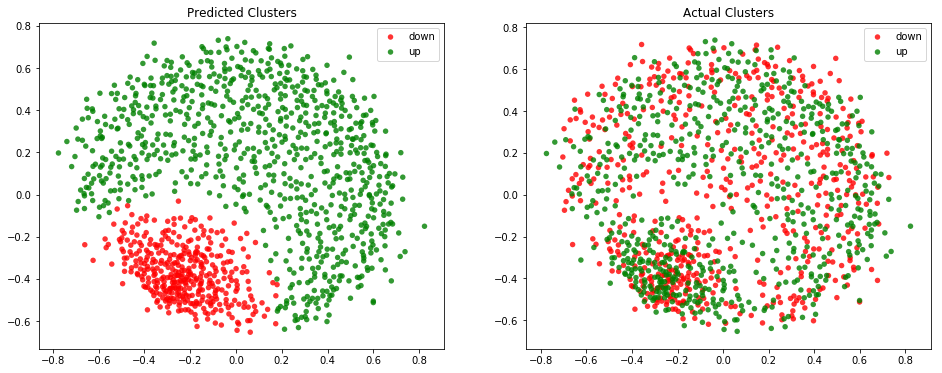

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

# distance between any pair of documents
dist = 1 - cosine_similarity(dtm)
cluster_dict={0:'down', 1:'up'}

# represent data to 2-dimension space
# compute coordinates using precomputed distance 
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# get color sets. Each cluster will be shown in a different color
colors = ["red", "green"]
groups = ['down', 'up']

# set up plot
fig = plt.figure(figsize=(16, 6))
# have two subplots horizontally placed
# plot the clusters
ax = fig.add_subplot(1, 2, 1)

# loop through each cluster to plot
for idx, g in enumerate(groups):
    # get coordinates of each cluster
    X=np.array([pos[i] for i in range(dtm.shape[0]) \
                if cluster_dict[clusters[i]]==g])
    ax.scatter(X[:,0], X[:,1], alpha=0.8, \
               c=colors[idx], edgecolors='none', s=30, label=g)
plt.legend()
plt.title('Predicted Clusters')

# plot the actual categories
ax = fig.add_subplot(1, 2, 2)

# loop through each actual category to plot
for idx, g in enumerate(groups):
    # get coordinates of each category
    X=np.array([pos[i] for i in range(dtm.shape[0]) \
                if cluster_dict[target[i]]==g])
    ax.scatter(X[:,0], X[:,1], alpha=0.8, \
               c=colors[idx], edgecolors='none', s=30, label=g)    
plt.title('Actual Clusters')
plt.legend()

plt.show()

### Deep Learning
- the code of this part saved as .py file